In [407]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.sparse

np.set_printoptions(precision = 8)

In [451]:
Ph300 = scipy.io.loadmat('Ph300.mat')
Ph500 = scipy.io.loadmat('Ph500.mat')

ph300 = np.asarray(scipy.sparse.csc_matrix.todense(Ph300['Ph300']))
ph500 = np.asarray(scipy.sparse.csc_matrix.todense(Ph500['Ph500']))

In [452]:
w, v = np.linalg.eig(ph300)

vektor = np.array(v[:,0])
vektor_new = np.zeros((vektor.size, 2))

#print(ph300 @ vektor)
for i in range(vektor.size):
    val = vektor[i]
    if(val > 0):
        vektor_new[i,0] = val
    if(val <= 0):
        vektor_new[i,1] = val

#plt.scatter(range(0,10), w[0:10])

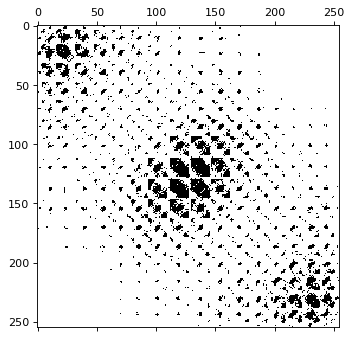

In [22]:
figure(figsize=(5, 5), dpi=80)
plt.spy(ph300[:,:])

### Funkcija koja iz vektora permutacije generira matricu permutacija

In [453]:
def permmat(vektor):
    n = vektor.size
    mat = np.zeros((n,n))
    for i in range(n):
        mat[i][vektor[i]] = 1
    return mat

### Funkcija $\mathbb{1}$-norme

In [454]:
def norma(B):
    n = max(B.shape)
    if(n == 0):
        return 0
    suma = np.sum(B);
    return suma/n

### Funkcija korak

Funkcija koja provjeri je li daljnja dekompozicija moguća, prima podmatricu B, threshold, indekse na kojima se $B$ nalazi 

$$B = B_{\text{main}}[\text{pocetna:zavrsna},\text{pocetna:zavrsna}]$$ 

te ukupnu dimenziju glavne matrice

In [620]:
def korak(B, thr, pocetna, zavrsna, n):
    u,s,v = np.linalg.svd(B)
    vektor = u[:,1]
    
    n1 = sum(vektor <= 0)
    n2 = sum(vektor > 0)

    Ppom = permmat(np.argsort(vektor))
    Bnew = Ppom @ B @ np.transpose(Ppom)
    
    P = np.eye(n)
    P[pocetna:zavrsna, pocetna:zavrsna] = Ppom
    
    if(norma(Bnew[0:n1,0:n1]) > thr and norma(Bnew[n1:n,n1:n]) > thr):
        return P, n1, n2, 0
    else:
        return P, n1, n2, 1

In [646]:
def SVDmetastable(B, thr, pocetna, zavrsna, n):
    blokovi = []
    permutacija = np.eye(n)
    
    P, n1, n2, flag = korak(B[pocetna:zavrsna, pocetna:zavrsna], thr, pocetna, zavrsna, n)
    
    print("P dimenzije: ", P.shape, "B dimenzije: ", B.shape)
    
    if(flag == 1):
        return blokovi, permutacija, 0
    
    permutacija = P @ permutacija
    Bnew = P @ B @ np.transpose(P)
 
    #provjeravamo može li se prva podmatrica dalje rastaviti
    flag1 = korak(Bnew[pocetna:(pocetna+n1), pocetna:(pocetna+n1)], thr, pocetna, pocetna+n1, n)[2]
    if(flag1 == 0):
        blokovi.append(n1)
    else:
        blok1, perm1, flag1 = SVDmetastable(Bnew, thr, pocetna, pocetna+n1, n)
        permutacija = perm1 @ permutacija
        Bnew = perm1 @ Bnew @ permutacija
    
    
    ##TREBA LI OVO U Bnew u SVDMetastab?
    
    #provjeravamo isto za drugu podmatricu
    flag1 = korak(Bnew[(pocetna+n1):zavrsna,(pocetna+n1):zavrsna], thr, pocetna, pocetna+n1, n)[2]
    if(flag1 == 0):
        blokovi.append(n2)
    else:
        blok1, perm1, flag1 = SVDmetastable(Bnew, thr, pocetna+n1, zavrsna, n)
        permutacija = perm1 @ permutacija
        Bnew = perm1 @ Bnew @ permutacija
        
    return blokovi, permutacija

In [649]:
def korak2(B, thr):
    u,s,v = np.linalg.svd(B)
    vektor = u[:,1]
    
    n1 = sum(vektor <= 0)
    n2 = sum(vektor > 0)

    P = permmat(np.argsort(vektor))
    Bnew = P @ B @ np.transpose(P)
    
    if(norma(Bnew[0:n1,0:n1]) > thr and norma(Bnew[n1:n,n1:n]) > thr):
        return P, n1, n2, 0
    else:
        return P, n1, n2, 1

In [679]:
def SVDmetastable2(B, thr):
    n = max(B.shape)
    blokovi = []
    permutacija = np.eye(n)
    
    P, n1, n2, flag = korak2(B, thr)
    
    if(flag == 1):
        #Ne možemo dalje rastavljat
        blokovi.append(n)
        return blokovi, permutacija
    else:
        print("Usao")
        B = P @ B @ np.transpose(P)
        blok1, perm1 = SVDmetastable2(B[0:n1,0:n1], thr)
        blok2, perm2 = SVDmetastable2(B[n1:n,n1:n], thr)
        permutacija[0:n1, 0:n1] = perm1
        permutacija[n1:n, n1:n] = perm2
        blokovi = blok1 + blok2
        return blokovi, permutacija

215 40 1
215 40 0
[255]


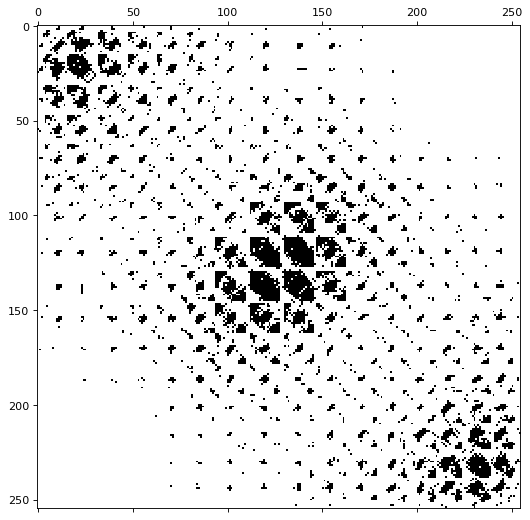

In [681]:
thr = .5
k = max(ph300.shape)
P,n1,n2,flag = korak2(ph300, .8)
print(n1,n2,flag)
P,n1,n2,flag = korak(ph300, .8,0,255,255)
print(n1,n2,flag)
blokovi, P = SVDmetastable2(ph300,thr)

ph = P @ ph300 @ np.transpose(P)

print(blokovi)
figure(figsize=(8, 8), dpi=80)
plt.spy(ph)

[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]] 3 2 0


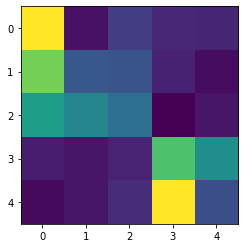

In [672]:
B = np.array([[0.1655,0.0393,0.0887,0.0192,0.6872],
             [0.0252,0.1888,0.1788,0.5436,0.0636],
             [0.0428,0.3154,0.2527,0.3875,0.0015],
             [0.0720,0.0344,0.1252,0.6884,0.0799],
             [0.3408,0.0421,0.0667,0.0544,0.4959]])

blokovi, P = SVDmetastable2(B,.8)

P, n1, n2, flag = korak2(B, .8)
print(P, n1, n2, flag)
B = P @ B @ np.transpose(P)
plt.imshow(B)

[[0.6884 0.0344 0.1252 0.0799 0.072 ]
 [0.5436 0.1888 0.1788 0.0636 0.0252]
 [0.3875 0.3154 0.2527 0.0015 0.0428]
 [0.0544 0.0421 0.0667 0.4959 0.3408]
 [0.0192 0.0393 0.0887 0.6872 0.1655]]
0.9049333333333333
[[0.4959 0.3408]
 [0.6872 0.1655]]
0.8447
3 2


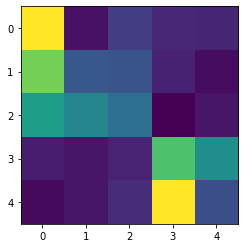

In [437]:
B = np.array([[0.1655,0.0393,0.0887,0.0192,0.6872],
             [0.0252,0.1888,0.1788,0.5436,0.0636],
             [0.0428,0.3154,0.2527,0.3875,0.0015],
             [0.0720,0.0344,0.1252,0.6884,0.0799],
             [0.3408,0.0421,0.0667,0.0544,0.4959]])

n = 5
P, n1, n2, flag = korak(B, 0.8, 5)
Bnew = P @ B @ np.transpose(P)
print(Bnew)

n = n1+n2

print(norma(Bnew[0:n1, 0:n1]))
print(Bnew[n1:n, n1:n])
print(norma(Bnew[n1:n, n1:n]))
print(n1,n2)

plt.imshow(Bnew)

3
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


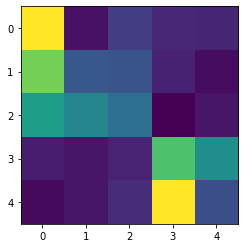

In [423]:
B = np.array([[0.1655,0.0393,0.0887,0.0192,0.6872],
             [0.0252,0.1888,0.1788,0.5436,0.0636],
             [0.0428,0.3154,0.2527,0.3875,0.0015],
             [0.0720,0.0344,0.1252,0.6884,0.0799],
             [0.3408,0.0421,0.0667,0.0544,0.4959]])
u,s,v = np.linalg.svd(B)

vektor = u[:,1]

print(sum(vektor < 0))

P = permmat(np.argsort(vektor))
print(P)

B_t = P@B@np.transpose(P)
plt.imshow(B_t)

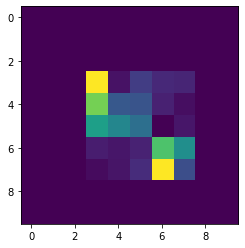

In [534]:
# B = np.array([[0.1655,0.0393,0.0887,0.0192,0.6872,0],
#             [0.0252,0.1888,0.1788,0.5436,0.0636,0],
#             [0.0428,0.3154,0.2527,0.3875,0.0015,0],
#             [0.0720,0.0344,0.1252,0.6884,0.0799,0],
#             [0.3408,0.0421,0.0667,0.0544,0.4959,0],
#             [0,0,0,0,0,0]]) 

B = np.array([[0.1655,0.0393,0.0887,0.0192,0.6872],
             [0.0252,0.1888,0.1788,0.5436,0.0636],
             [0.0428,0.3154,0.2527,0.3875,0.0015],
             [0.0720,0.0344,0.1252,0.6884,0.0799],
             [0.3408,0.0421,0.0667,0.0544,0.4959]])
A = np.zeros((10,10))
A[3:8,3:8] = B


P, n1, n2, flag = korak(B, 0.8, 3, 8, 10)


#P = np.eye(n)
#P[0:k,0:k] = Ppom

A = P @ A @ np.transpose(P)
plt.imshow(A)